In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import time
from torch_geometric.data import Data, DataLoader
import numpy.linalg as LA
import networkx as nx
from torch_geometric.utils import to_networkx

In [2]:
def build_graph(L):
    start = time.time()
    coord=[[i,j] for i in range(28) for j in range(28)]

    edge_1=[]
    edge_2=[]
    edge_weight=[]
    for i in range(28*28):
        for j in range(28*28):
            if not i==j:
                z=LA.norm(np.array(coord[i])-np.array(coord[j]))
                if float(z)<L:
                    edge_1.append(i)
                    edge_2.append(j)
                    edge_weight.append(np.exp(-z**2))    
    edge_index=[edge_1,edge_2]
    end = time.time()
    print("building time: "+ str(end - start))
    return edge_index, edge_weight

In [3]:
def load_and_transform(train_batch, test_batch, edge_index, edge_weight):
    start = time.time()
    mnist_train=datasets.MNIST('data', download=True, train=True)
    train_X=mnist_train.train_data/256
    train_y=mnist_train.targets
    mnist_test=datasets.MNIST('data', download=True, train=False)
    test_X=mnist_test.test_data/256
    test_y=mnist_test.targets

    train_list =[]
    test_list=[]
    train_size=train_X.size(0)
    test_size=test_X.size(0)
    
    edge_torch = torch.tensor(edge_index, dtype=torch.long)
    edge_w_torch=torch.tensor(edge_weight).float()
    for i in range(train_size):
        train_list.append(Data(x=train_X[i].view(-1).float()[:,None],y=train_y[i], edge_index=edge_torch,edge_attr=edge_w_torch))
        if i<test_size:
            test_list.append(Data(x=test_X[i].view(-1).float()[:,None],y=test_y[i], edge_index=edge_torch,edge_attr=edge_w_torch))
    
    train_loader = DataLoader(train_list, batch_size=train_batch)
    test_loader = DataLoader(test_list, batch_size=test_batch)
    end = time.time()
    print("loading time: "+ str(end - start))
    return train_loader, test_loader, train_list, test_list

In [4]:
def draw_sample(sample):
    color=[]
    for i in sample.x:
        if i>0:
            color.append("red")
        else:
            color.append('black')
    coord=[[i,j] for i in range(28) for j in range(28)]
    pos = {i: tuple(coord[i]) for i in range(28*28)} 
    G = to_networkx(sample, to_undirected=True)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax=nx.draw(G,pos=pos, node_size=20,node_color=color)
    print(f'Number of nodes: {sample.num_nodes}')
    print(f'Number of edges: {sample.num_edges}')
    print(f'Average node degree: {sample.num_edges / sample.num_nodes:.2f}')
    print(f'Target value: {sample.y}')

def accuracy(pred, target):
        pred=pred.max(axis=1)[1]
        corrects = 100.0 *torch.eq(pred, target).sum().float() / len(target)
        return corrects.item()

building time: 11.961610794067383


/home/harsanyi/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/harsanyi/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:63: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


loading time: 2.5023043155670166
Number of nodes: 784
Number of edges: 5940
Average node degree: 7.58
Target value: 5


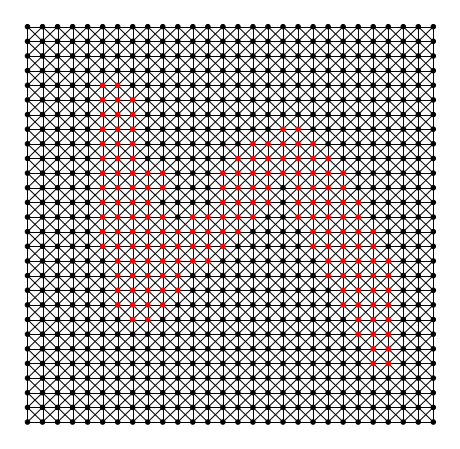

In [5]:
edge_index, edge_weight=build_graph(2)
train_loader, test_loader, train_list, test_list =load_and_transform(100, 1000, edge_index, edge_weight)

sample=train_list[0]
draw_sample(sample)

In [6]:
from torch_geometric.nn import ChebConv
class Cheb(nn.Module):
    def __init__(self,K,hidden=10):
        super().__init__()
        self.conv1 = ChebConv(1,hidden ,K=K)
        self.dense1 = nn.Linear(784*hidden,10)
        self.relu = nn.ReLU()
        self.hidden=hidden
        
        self.layers = [self.conv1]
        
    def forward(self, X,edge_index,edge_attr):
        h=X
        for layer in self.layers:
            h = layer(h, edge_index,edge_attr)
            h = self.relu(h)
        h = h.view(-1,784*self.hidden)
        h = self.dense1(h)
        return h

In [7]:
def plot_history(history):
    fig = plt.figure(figsize=(15, 5))

    # Plot the loss history
    f1 = fig.add_subplot(121)
    plt.title('Loss')
    plt.plot(history['train_loss'][0], color='blue', label='train')
    plt.xlabel('Batches')
    plt.legend()

    # Plot the accuracy history
    f2 = fig.add_subplot(122)
    plt.title('Classification Accuracy')
    plt.plot(history['train_accuracy'][0], color='blue', label='train')
    plt.xlabel('Batches')
    plt.legend()
    
    plt.show()

In [13]:
def training_loop(DENSITY, BATCH, EPOCHS, MODEL, OPTIMIZER):
    
    edge_index, edge_weight=build_graph(DENSITY)
    train_loader, test_loader, train_list, test_list =load_and_transform(BATCH, 1000, edge_index, edge_weight)
    
    criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
    history = {'train_loss': [], 'train_accuracy': [], 'test_loss': [],'test_accuracy': [], 'epoch_loss':
              [], 'epoch_accuracy':[]}
    
    for epoch in range(EPOCHS):
        start=time.time()
        train_loss = []
        train_acc = []
        test_loss = 0
        test_acc = 0
        for step,data in enumerate(train_loader):
            print(step)
            OPTIMIZER.zero_grad()  # Clear gradients.
            y_out= MODEL(data.x, data.edge_index, data.edge_attr)  # Perform a single forward pass.
            loss = criterion(y_out,  data.y)  # Compute the loss solely based on the training nodes.
            loss.backward()  # Derive gradients.
            OPTIMIZER.step()  # Update parameters based on gradients.
            train_loss.append(loss.detach().item())
            train_acc.append(accuracy(y_out, data.y))
            
        epoch_loss=float("{:.2f}".format(sum(train_loss)/(step+1)))
        epoch_acc=float("{:.2f}".format(sum(train_acc)/(step+1)))
        
        for step,data in enumerate(test_loader):
            y_out=MODEL(data.x, data.edge_index, data.edge_attr)
            loss = criterion(y_out,  data.y) 
            test_loss += loss.detach().item()
            test_acc += accuracy(y_out, data.y)
        test_loss = test_loss / (step+1)
        test_acc = test_acc / (step+1)
        end=time.time()
        print(f"Epoch: {epoch} | Train loss: {epoch_loss} | Train accuracy: {epoch_acc}  | Test loss: {test_loss} | Test accuracy: {test_acc}| Time: {end-start}")
        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_acc)
        history['test_accuracy'].append(test_acc)
        history['test_loss'].append(test_loss)
        history['epoch_loss'].append(epoch_loss)
        history['epoch_accuracy'].append(epoch_acc)
    return history

In [14]:
MODEL=Cheb(25,10)
OPTIMIZER =  torch.optim.Adam(MODEL.parameters(), lr=0.03)   
BATCH = 100
EPOCHS = 1
DENSITY=2

history= training_loop(DENSITY, BATCH, EPOCHS, MODEL, OPTIMIZER)


building time: 18.41012954711914
loading time: 2.7633724212646484
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260


In [433]:
from torchsummary import summary
summary(MODEL)

Layer (type:depth-idx)                   Param #
├─ChebConv: 1-1                          260
├─Linear: 1-2                            78,410
├─ReLU: 1-3                              --
Total params: 78,670
Trainable params: 78,670
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─ChebConv: 1-1                          260
├─Linear: 1-2                            78,410
├─ReLU: 1-3                              --
Total params: 78,670
Trainable params: 78,670
Non-trainable params: 0

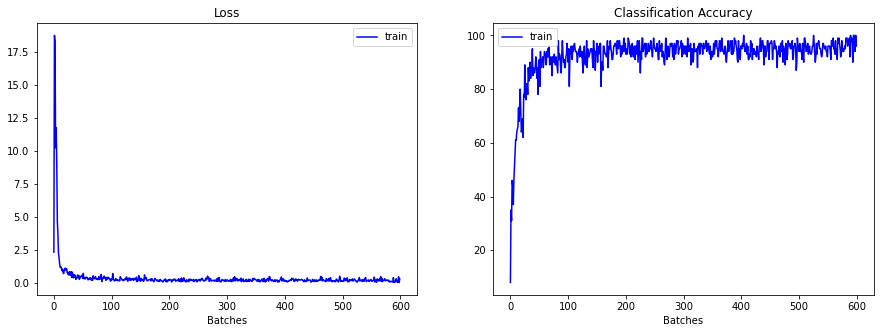

In [16]:
plot_history(history)

In [318]:
model = Cheb()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.03)  # Define optimizer.

def get_accuracy(prediction, target, batch_size):
        corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).sum()
        accuracy = 100.0 * corrects / batch_size
        return accuracy.item()
history = {'train_loss': [], 'train_accuracy': [], 'test_loss': [],'test_accuracy': []}
n_epochs = 20

for epoch in range(n_epochs):
    start=time.time()
    train_loss = 0.0
    train_acc = 0.0
    test_loss = 0.0
    test_acc = 0.0
    for step,data in enumerate(train_loader):
        optimizer.zero_grad()  # Clear gradients.
        y_out= model(data.x, data.edge_index, data.edge_attr)  # Perform a single forward pass.
        loss = criterion(y_out,  data.y)  # Compute the loss solely based on the training nodes.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        train_loss += loss.detach().item()
        train_acc += get_accuracy(y_out, data.y, 100)
    train_loss = train_loss / (step+1)
    train_acc = train_acc / (step+1)
    for step,data in enumerate(test_loader):
        y_out=model(data.x, data.edge_index, data.edge_attr)
        loss = criterion(y_out,  data.y) 
        test_loss += loss.detach().item()
        test_acc += get_accuracy(y_out, data.y, 1000)
    test_loss = test_loss / (step+1)
    test_acc = test_acc / (step+1)
    end=time.time()
    print(f"Epoch: {epoch} | Train loss: {train_loss} | Train accuracy: {train_acc}")  
    print(f"Epoch: {epoch} | Test loss: {test_loss} | Test accuracy: {test_acc}| Time: {end-start}")
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_acc)
    history['test_accuracy'].append(test_acc)
    history['test_loss'].append(test_loss)

Epoch: 0 | Train loss: 0.3395987970475107 | Train accuracy: 92.40166666666667
Epoch: 0 | Test loss: 0.17347802817821503 | Test accuracy: 94.78000106811524| Time: 94.11543726921082
Epoch: 1 | Train loss: 0.13972616360368192 | Train accuracy: 96.02
Epoch: 1 | Test loss: 0.21813003420829774 | Test accuracy: 94.33000030517579| Time: 96.32735061645508
Epoch: 2 | Train loss: 0.16184364077887342 | Train accuracy: 95.71166666666667
Epoch: 2 | Test loss: 0.24342975541949272 | Test accuracy: 95.05000076293945| Time: 93.93657755851746
Epoch: 3 | Train loss: 0.13091759585236407 | Train accuracy: 96.72166666666666
Epoch: 3 | Test loss: 0.31400756239891053 | Test accuracy: 94.85| Time: 96.85681200027466
Epoch: 4 | Train loss: 0.1290938177770391 | Train accuracy: 97.14666666666666
Epoch: 4 | Test loss: 0.30984415486454964 | Test accuracy: 95.7400001525879| Time: 94.5721287727356
Epoch: 5 | Train loss: 0.1487338120213826 | Train accuracy: 97.18
Epoch: 5 | Test loss: 0.43232338428497313 | Test accuracy